iter:1 training loss: 0.0, val loss: 0.0
iter:2 training loss: 0.0, val loss: 0.0
iter:3 training loss: 0.0, val loss: 0.0
iter:4 training loss: 0.0, val loss: 0.0
Took 0.011581182479858398s for 5 epochs


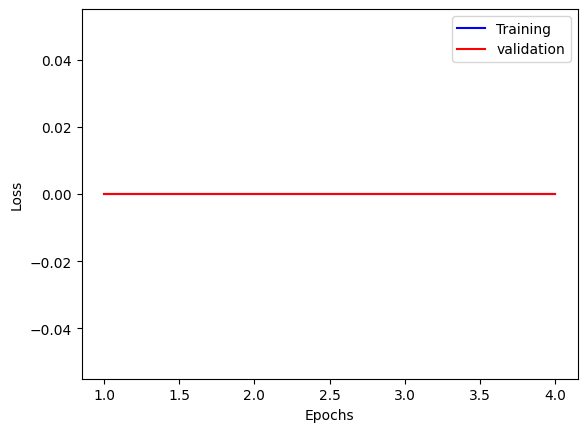

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from dataclasses import dataclass

torch.manual_seed(10)



input_size = 2
learning_rate = 0.01
max_iters = 5
dataset_size = 1024*4
batch_size = dataset_size


iters = []
loss_value = []
val_loss_value = []


def sample_data(split = 'train', batch_size = batch_size):
    if split != 'train':
        curr_data = validation_dataset
    else:
        curr_data = training_dataset
    curr_data = curr_data[torch.randperm(curr_data.shape[0])][:batch_size]
    a, b = curr_data.shape
    
    sparsity_vector = torch.rand(a, b)
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    # X = curr_data * sparsity_mat
    X = curr_data
    return X



DEVICE = torch.device('cpu')

@dataclass
class Config:
    input_size : int
    hidden_size : int = 2
    layers : int = 2

class Two_Two(nn.Module):
    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.Linear(hidden_size,hidden_size) )
    
    def forward(self, idx):
        return self.layers(idx)

class Model(nn.Module):
    def __init__(self, config : Config) -> None:
        super().__init__()
        self.config = config
        self.layers = nn.Sequential(
                        nn.Linear(config.input_size, config.hidden_size),
                        nn.ReLU(),
                        nn.Linear(config.hidden_size, 1),
                    )

    
    def forward(self, idx : torch.Tensor):
        count = self.layers(idx) 

        loss = nn.MSELoss()
        
        return count, loss(count.squeeze(-1), count.sum(-1))


training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model(Config(input_size= input_size))

def get_accuracy():
    a= sample_data(split = 'val', batch_size= 1024)
    n = (model(a)[0].argmax(-1) == (a>0).sum(-1))
    print("val accuracy",n.sum()/a.shape[0])
optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-4)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X =  sample_data()
    count, loss = model(X)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V = sample_data(split = 'val')
            _, val_loss= model(X_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    #loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

In [9]:
model.layers[0].weight

Parameter containing:
tensor([[-0.0757, -0.0376],
        [ 0.5545,  0.0796]], requires_grad=True)

In [11]:
X = sample_data()
X

tensor([[0.6954, 0.8820],
        [0.0605, 0.9477],
        [0.5807, 0.5673],
        ...,
        [0.6674, 0.3878],
        [0.8413, 0.1498],
        [0.3056, 0.3317]])

In [12]:
X

tensor([[0.6954, 0.8820],
        [0.0605, 0.9477],
        [0.5807, 0.5673],
        ...,
        [0.6674, 0.3878],
        [0.8413, 0.1498],
        [0.3056, 0.3317]])

In [14]:
model(X)[0], X.sum(-1)

(tensor([[0.2831],
         [0.2827],
         [0.2829],
         ...,
         [0.2829],
         [0.2830],
         [0.2827]], grad_fn=<AddmmBackward0>),
 tensor([1.5774, 1.0082, 1.1479,  ..., 1.0552, 0.9912, 0.6373]))